# This notebook contains experiments with Amazon reviews

In [ ]:
import numpy as np
import pandas as pd
from experiment_utils import *
# Adjust the path for Jupyter notebooks
import os
import sys
from joblib import dump, load
from tqdm import tqdm
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)
from comparator.TI_estimator.simulation import *
from comparator.TI_estimator.Qmod import *

src_path = os.path.abspath("../src")
sys.path.append(src_path)

from models import *
from utils import *

import matplotlib.pyplot as plt
import seaborn as sns

p = 768 

In [2]:
def text_trial_single(n=2000, p=768, adjusted_ate=1, unadjusted_ate=2, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    if p==768:
        ate = unadjusted_ate
    else:
        ate = adjusted_ate
    sampled_df = simulated_df.sample(n=n,replace=False,random_state=random_seed).reset_index()    
    
    # Qmodel
    mod = QNet(batch_size = 64, # batch size for training
           a_weight = 0.1,  # loss weight for A ~ text
           y_weight = 0.1,  # loss weight for Y ~ A + text
           mlm_weight=1.0,  # loss weight for DistlBert
           modeldir='model/train') # directory for saving the best model
    mod.train(sampled_df['text'],  # texts in training data
           sampled_df['T'],     # treatments in training data
          sampled_df['C'],     # confounds in training data, binary
          sampled_df['Y'],     # outcomes in training data
          epochs=1,   # the maximum number of training epochs
          # learning_rate = 2e-5)  # learning rate for the training
          learning_rate = 1e-3) 
    Q0, Q1, A, Y, _ = mod.get_Q(sampled_df['text'], sampled_df['T'], sampled_df['C'], sampled_df['Y'])
    g = get_propensities(A, Q0, Q1, 
                     model_type='GaussianProcessRegression', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR
    att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
    ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
    

    # our method
    df = pd.merge(sampled_df, embeddings, on='text', how='inner')
    df.drop(columns=['index','Unnamed: 0','text'],inplace=True)
    df.rename(columns={'C': 'X769','T':'A', 'Y':'y'},inplace=True)
    df['mu0']=Q0
    df['mu1']=Q1
    if not stds_return:
        ates = single_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        all_ate = {'true_ate':ate,
                'ti_att':ti_att,
                'ti_ate':ti_ate,
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw']}
        return all_ate, _
    else:
        ates, stds = single_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
    
        all_ate = {'true_ate':ate,
                    'att_ti':att_ti,
                    'ate_ti':ate_ti,
                    'ate_mr':ates['ate_mr'],
                    'ate_ipw':ates['ate_ipw'],
                    'ate_amr':ates['ate_amr'],
                    'ate_aipw':ates['ate_aipw']}
        
        all_std = {'std_att_ti': std_att_ti,
                    'std_ate_ti': std_ate_ti,
                    'std_mr': stds['ate_mr'],
                    'std_ipw': stds['ate_ipw'],
                    'std_amr': stds['ate_amr'],
                    'std_aipw': stds['ate_aipw']}
    

        return all_ate, all_std
def text_trial(num_trials=200,n=2000, p=768, adjusted_ate=1, unadjusted_ate=3, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    ate_results = {
    'true_ate': [],
    'att_ti': [],
    'ate_ti': [],
    'ate_mr': [],
    'ate_ipw': [],
    'ate_amr': [],
    'ate_aipw': []
    }
    std_results = {
        'std_att_ti': [],
        'std_ate_ti': [],
        'std_mr': [],
        'std_ipw': [],
        'std_amr': [],
        'std_aipw': []
    }

    
    for i in tqdm(range(num_trials)):
        if not stds_return:
            single_all_ate = text_trial_single(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            return ate_results
        else:
            single_all_ate, single_all_std = text_trial_single(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            for key, value in single_all_std.items():
                std_results[key].append(value)

    return ate_results, std_results
    

In [10]:
raw_df = pd.read_csv('../data/music/music.csv')
simulated_df, offset =run_simulation(raw_df, propensities=[0.8, 0.6], 
                            beta_t=1.0,  # 1.0, 0.0
                            beta_c=50.0, # 50.0, 100.0
                            gamma=1,    # 1.0, 4.0
                            cts=True)    
simulated_df = simulated_df.drop_duplicates(subset='text')
adjusted_ate = ATE_adjusted(simulated_df['C'], simulated_df['T'], simulated_df['Y'])
unadjusted_ate = ATE_unadjusted(simulated_df['T'], simulated_df['Y'])
print('adjusted ATE: ', adjusted_ate)
print('unadjusted ATE: ', unadjusted_ate)


Offset: 0.629293401965372
[0.2, 0.8]
[0.4, 0.6]
adjusted ATE:  1.0049071276143753
unadjusted ATE:  2.069297192109347


In [ ]:
ate_results, std_results = text_trial(num_trials=50,n=1000, p=768, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='original',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False)
# Define the file path
ate_output_file = "results/music/ate.joblib"
std_output_file = "results/music/std.joblib"

# Ensure the directory exists
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

# Save the results using joblib
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

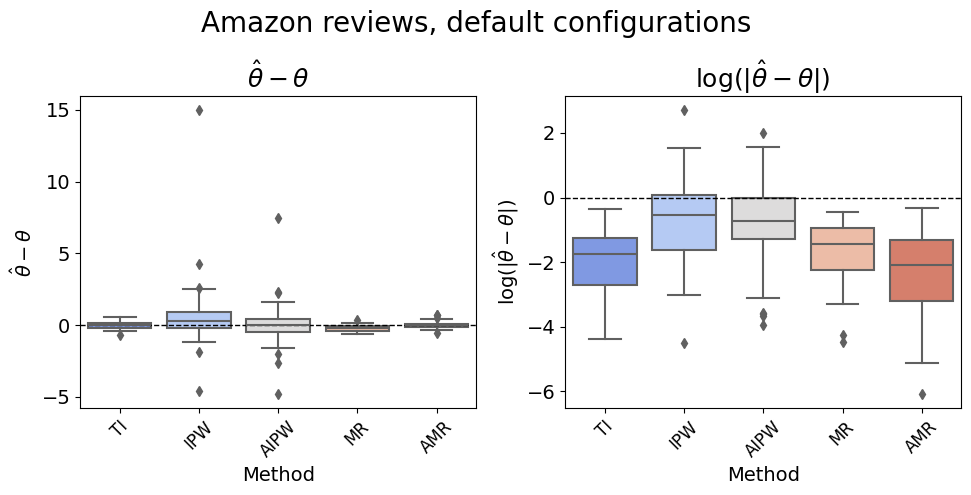

  Method  Mean_Diff  Std_Diff  Mean_Abs_Diff  Std_Abs_Diff      RMSE  Std_RMSE
0     TI  -0.026290  0.244684       0.190726      0.155515  0.246092  0.489367
1    IPW   0.623477  2.386634       1.122118      2.196725  2.466728  4.773269
2   AIPW   0.055020  1.548198       0.898672      1.261877  1.549176  3.096396
3     MR  -0.226189  0.217865       0.256797      0.180780  0.314048  0.435729
4    AMR   0.019224  0.246390       0.177259      0.172212  0.247139  0.492780


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import load

# -----------------------
# Load data
# -----------------------
ate_results = load('results/music/ate.joblib')

# Original list of methods
methods = ['att_ti', 'ate_ipw', 'ate_aipw', 'ate_mr', 'ate_amr']

# Map each method to a nicer display name
short_methods = {
    'att_ti':   'TI',
    'ate_ipw':  'IPW',
    'ate_aipw': 'AIPW',
    'ate_mr':   'MR',
    'ate_amr':  'AMR'
}

# Set the order in which you want these short names to appear
ordered_short_methods = ['TI', 'IPW', 'AIPW', 'MR', 'AMR']

# Extract the true ATE
true_ate = np.array(ate_results['true_ate'])

# -----------------------
# Calculate metrics
# -----------------------
n = 1000
results = {}

for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        # 'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        # 'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# -----------------------
# Prepare DataFrame for plotting
# -----------------------
plot_data = []

for method, metrics in results.items():
    # Use the short (capitalized) name instead of the raw method
    short_name = short_methods[method]
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            # Avoid log(0) issues
            values = values[values > 0]  
        plot_data.append(pd.DataFrame({
            'Method': [short_name] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data, ignore_index=True)

# Adjust method order using the capitalized names
plot_df['Method'] = pd.Categorical(
    plot_df['Method'], 
    categories=ordered_short_methods,
    ordered=True
)

# -----------------------
# Define custom titles for each metric
# -----------------------
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias':        r'$\log(|\hat{\theta}-\theta|)$',
    # 'sqrt_n_bias':    r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    # 'sqrt_n_abs_bias':r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# -----------------------
# Plot metrics
# -----------------------
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(10, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',  # or 'Set2', 'Blues', etc.
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        # Identify which short method corresponds to this box
        short_method_name = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == short_method_name]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
    
    # Horizontal dashed line at y=0
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

plt.suptitle('Amazon reviews, default configurations', fontsize=20)
plt.tight_layout()
plt.show()

# -----------------------
# Compute summary statistics
# -----------------------
summary_stats = []

for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    
    # For completeness; not a common definition to use std of RMSE, but carried over from your snippet
    std_rmse = np.std(diffs * 2)  
    
    summary_stats.append({
        'Method': short_methods[method],  # Use the short/capitalized name here
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)


# Experiment of changing potential outcome model for Qmod

In [12]:
raw_df = pd.read_csv('../data/music/music.csv')
simulated_df, offset =run_simulation(raw_df, propensities=[0.8, 0.6], 
                            beta_t=1.0,  # 1.0, 0.0
                            beta_c=50.0, # 50.0, 100.0
                            gamma=1,    # 1.0, 4.0
                            cts=True)    
simulated_df = simulated_df.drop_duplicates(subset='text')
adjusted_ate = ATE_adjusted(simulated_df['C'], simulated_df['T'], simulated_df['Y'])
unadjusted_ate = ATE_unadjusted(simulated_df['T'], simulated_df['Y'])
print('adjusted ATE: ', adjusted_ate)
print('unadjusted ATE: ', unadjusted_ate)


Offset: 0.629293401965372
[0.2, 0.8]
[0.4, 0.6]
adjusted ATE:  0.9619616701880369
unadjusted ATE:  2.0336679632481154


In [17]:
def text_trial_single_v2(n=2000, p=768, adjusted_ate=1, unadjusted_ate=2, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    if p==768:
        ate = unadjusted_ate
    else:
        ate = adjusted_ate
    sampled_df = simulated_df.sample(n=n,replace=False,random_state=random_seed).reset_index()  
    

    # our method
    df = pd.merge(sampled_df, embeddings, on='text', how='inner')
    df.drop(columns=['index','Unnamed: 0','text'],inplace=True)
    df.rename(columns={'C': 'X769','T':'A', 'Y':'y'},inplace=True)
    if not stds_return:
        df_result,ates = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(df_result['A'], Q0, Q1, 
                     model_type='KNearestNeighbors', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                'ti_att':ti_att,
                'ti_ate':ti_ate,
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw']}
        return all_ate
    else:
        df_result, ates, stds = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(A, Q0, Q1, 
                     model_type='KNearestNeighbors', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                    'att_ti':att_ti,
                    'ate_ti':ate_ti,
                    'ate_mr':ates['ate_mr'],
                    'ate_ipw':ates['ate_ipw'],
                    'ate_amr':ates['ate_amr'],
                    'ate_aipw':ates['ate_aipw']}
        
        all_std = {'std_att_ti': std_att_ti,
                    'std_ate_ti': std_ate_ti,
                    'std_mr': stds['ate_mr'],
                    'std_ipw': stds['ate_ipw'],
                    'std_amr': stds['ate_amr'],
                    'std_aipw': stds['ate_aipw']}
    

        return all_ate, all_std
def text_trial_v2(num_trials=200,n=2000, p=768, adjusted_ate=1, unadjusted_ate=3, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    ate_results = {
    'true_ate': [],
    'att_ti': [],
    'ate_ti': [],
    'ate_mr': [],
    'ate_ipw': [],
    'ate_amr': [],
    'ate_aipw': []
    }
    std_results = {
        'std_att_ti': [],
        'std_ate_ti': [],
        'std_mr': [],
        'std_ipw': [],
        'std_amr': [],
        'std_aipw': []
    }

    
    for i in tqdm(range(num_trials)):
        if not stds_return:
            single_all_ate, = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            return ate_results
        else:
            single_all_ate, single_all_std = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            for key, value in single_all_std.items():
                std_results[key].append(value)

    return ate_results, std_results
    

In [ ]:
ate_results, std_results = text_trial_v2(num_trials=200,n=1000, p=768, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='lr',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False)


100%|██████████| 200/200 [47:40<00:00, 14.30s/it]


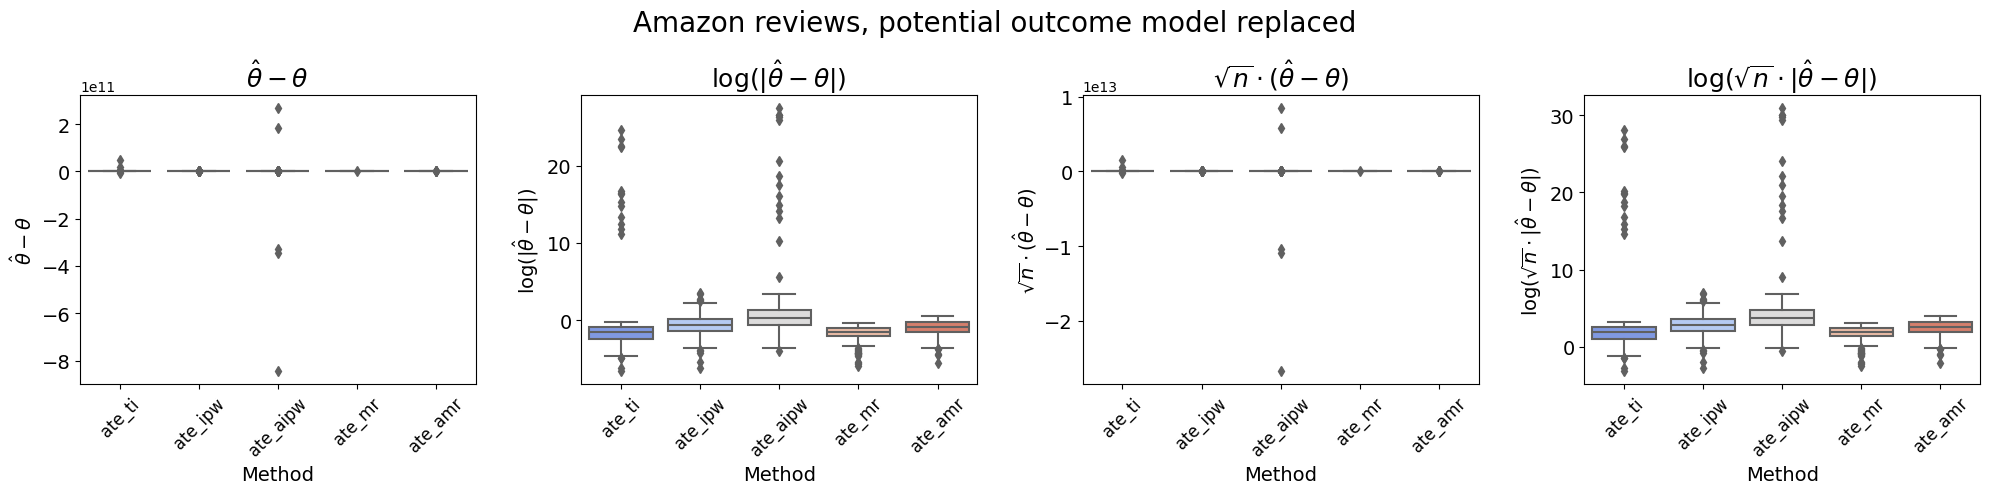

     Method     Mean_Diff      Std_Diff  Mean_Abs_Diff  Std_Abs_Diff  \
0    ate_ti  3.277982e+08  3.668389e+09   3.835832e+08  3.662976e+09   
1   ate_ipw  6.516720e-01  3.877123e+00   1.504535e+00  3.632236e+00   
2  ate_aipw -5.348609e+09  7.214221e+10   9.853170e+09  7.166604e+10   
3    ate_mr -2.235761e-01  1.874146e-01   2.438022e-01  1.602216e-01   
4   ate_amr  2.029854e-01  6.348918e-01   5.322248e-01  4.012822e-01   

           RMSE      Std_RMSE  
0  3.683005e+09  7.336778e+09  
1  3.931509e+00  7.754247e+00  
2  7.234021e+10  1.442844e+11  
3  2.917370e-01  3.748292e-01  
4  6.665513e-01  1.269784e+00  


In [ ]:
# # Extract keys and true ATE

methods = [ 'ate_ti',  'ate_ipw', 'ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 1000
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(20, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Amazon reviews, potential outcome model replaced', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []


for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)


In [4]:
def text_trial_single_v2(n=2000, p=768, adjusted_ate=1, unadjusted_ate=2, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    if p==768:
        ate = unadjusted_ate
    else:
        ate = adjusted_ate
    sampled_df = simulated_df.sample(n=n,replace=False,random_state=random_seed).reset_index()  
    

    # our method
    df = pd.merge(sampled_df, embeddings, on='text', how='inner')
    df.drop(columns=['index','Unnamed: 0','text'],inplace=True)
    df.rename(columns={'C': 'X769','T':'A', 'Y':'y'},inplace=True)
    if not stds_return:
        df_result,ates = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(df_result['A'], Q0, Q1, 
                     model_type='GaussianProcessRegression', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                'ti_att':ti_att,
                'ti_ate':ti_ate,
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw']}
        return all_ate
    else:
        df_result, ates, stds = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(A, Q0, Q1, 
                     model_type='GaussianProcessRegression', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                    'att_ti':att_ti,
                    'ate_ti':ate_ti,
                    'ate_mr':ates['ate_mr'],
                    'ate_ipw':ates['ate_ipw'],
                    'ate_amr':ates['ate_amr'],
                    'ate_aipw':ates['ate_aipw']}
        
        all_std = {'std_att_ti': std_att_ti,
                    'std_ate_ti': std_ate_ti,
                    'std_mr': stds['ate_mr'],
                    'std_ipw': stds['ate_ipw'],
                    'std_amr': stds['ate_amr'],
                    'std_aipw': stds['ate_aipw']}
    

        return all_ate, all_std
def text_trial_v2(num_trials=200,n=2000, p=768, adjusted_ate=1, unadjusted_ate=3, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    ate_results = {
    'true_ate': [],
    'att_ti': [],
    'ate_ti': [],
    'ate_mr': [],
    'ate_ipw': [],
    'ate_amr': [],
    'ate_aipw': []
    }
    std_results = {
        'std_att_ti': [],
        'std_ate_ti': [],
        'std_mr': [],
        'std_ipw': [],
        'std_amr': [],
        'std_aipw': []
    }

    
    for i in tqdm(range(num_trials)):
        if not stds_return:
            single_all_ate, = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            return ate_results
        else:
            single_all_ate, single_all_std = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            for key, value in single_all_std.items():
                std_results[key].append(value)

    return ate_results, std_results
    

In [9]:
ate_results, std_results = text_trial_v2(num_trials=50,n=1500, p=768, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='lr',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False)
# Define the file path
ate_output_file = "results/music/ate_lr.joblib"
std_output_file = "results/music/std_lr.joblib"

# Ensure the directory exists
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

# Save the results using joblib
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

100%|██████████| 50/50 [19:30<00:00, 23.41s/it]

Results saved to results/music/ate_lr.joblib
Results saved to results/music/std_lr.joblib


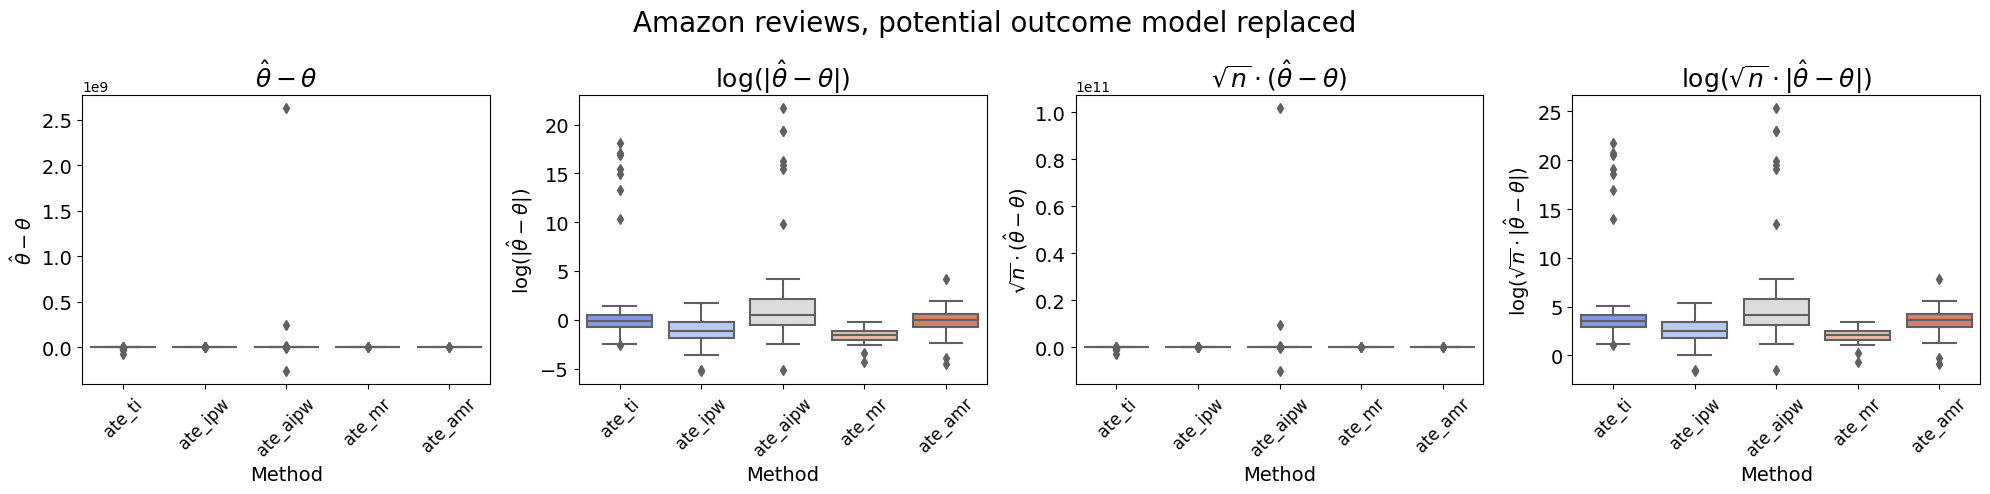

     Method     Mean_Diff      Std_Diff  Mean_Abs_Diff  Std_Abs_Diff  \
0    ate_ti -2.579814e+06  1.102721e+07   2.581016e+06  1.102693e+07   
1   ate_ipw  3.709170e-01  1.318574e+00   7.899358e-01  1.119026e+00   
2  ate_aipw  5.226317e+07  3.713215e+08   6.309777e+07  3.696347e+08   
3    ate_mr -2.187264e-01  1.765321e-01   2.372848e-01  1.506677e-01   
4   ate_amr  7.989302e-01  9.397268e+00   2.485927e+00  9.097643e+00   

           RMSE      Std_RMSE  
0  1.132497e+07  2.205443e+07  
1  1.369751e+00  2.637148e+00  
2  3.749815e+08  7.426431e+08  
3  2.810780e-01  3.530642e-01  
4  9.431168e+00  1.879454e+01  


In [ ]:
# # Extract keys and true ATE
ate_results = load('results/music/ate_lr.joblib')
methods = [ 'ate_ti',  'ate_ipw', 'ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 1500
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(20, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Amazon reviews, potential outcome model replaced', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []


for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)


# Introcucing interaction term in outcome regression, theta = 0.2

In [3]:
def text_trial_single_v2(n=2000, p=768, adjusted_ate=1, unadjusted_ate=2, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    if p==768:
        ate = unadjusted_ate
    else:
        ate = adjusted_ate
    sampled_df = simulated_df.sample(n=n,replace=False,random_state=random_seed).reset_index()  
    

    # our method
    df = pd.merge(sampled_df, embeddings, on='text', how='inner')
    df.drop(columns=['index','Unnamed: 0','text'],inplace=True)
    df.rename(columns={'C': 'X769','T':'A', 'Y':'y'},inplace=True)
    if not stds_return:
        df_result,ates = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(df_result['A'], Q0, Q1, 
                     model_type='GaussianProcessRegression', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                'ti_att':ti_att,
                'ti_ate':ti_ate,
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw']}
        return all_ate
    else:
        df_result, ates, stds = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(A, Q0, Q1, 
                     model_type='GaussianProcessRegression', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                    'att_ti':att_ti,
                    'ate_ti':ate_ti,
                    'ate_mr':ates['ate_mr'],
                    'ate_ipw':ates['ate_ipw'],
                    'ate_amr':ates['ate_amr'],
                    'ate_aipw':ates['ate_aipw']}
        
        all_std = {'std_att_ti': std_att_ti,
                    'std_ate_ti': std_ate_ti,
                    'std_mr': stds['ate_mr'],
                    'std_ipw': stds['ate_ipw'],
                    'std_amr': stds['ate_amr'],
                    'std_aipw': stds['ate_aipw']}
    

        return all_ate, all_std
def text_trial_v2(num_trials=200,n=2000, p=768, adjusted_ate=1, unadjusted_ate=3, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    ate_results = {
    'true_ate': [],
    'att_ti': [],
    'ate_ti': [],
    'ate_mr': [],
    'ate_ipw': [],
    'ate_amr': [],
    'ate_aipw': []
    }
    std_results = {
        'std_att_ti': [],
        'std_ate_ti': [],
        'std_mr': [],
        'std_ipw': [],
        'std_amr': [],
        'std_aipw': []
    }

    
    for i in tqdm(range(num_trials)):
        if not stds_return:
            single_all_ate, = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            return ate_results
        else:
            single_all_ate, single_all_std = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            for key, value in single_all_std.items():
                std_results[key].append(value)

    return ate_results, std_results
    

In [50]:
raw_df = pd.read_csv('../data/music/music.csv')
simulated_df, offset = run_simulation(
    raw_df,
    propensities=[0.3, 0.9],
    beta_t=2.0,
    beta_c=20,
    gamma=2,
    cts=True,
    nonlinear=True  # <--- This triggers the more complicated outcome
)
simulated_df = simulated_df.drop_duplicates(subset='text')
adjusted_ate = ATE_adjusted(simulated_df['C'], simulated_df['T'], simulated_df['Y'])
unadjusted_ate = ATE_unadjusted(simulated_df['T'], simulated_df['Y'])
print('adjusted ATE: ', adjusted_ate)
print('unadjusted ATE: ', unadjusted_ate)


[0.7002237136465325, 0.29977628635346754]
[0.1, 0.9]
adjusted ATE:  3.172155244238862
unadjusted ATE:  0.23967805112280338


In [54]:
#simulated_df['propen']=[0.9]*simulated_df.shape[0]
ate_results, std_results = text_trial_v2(num_trials=50,n=1000, p=768, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=True, n_folds=3, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False)
# # Define the file path
ate_output_file = "results/music/ate_nn.joblib"
std_output_file = "results/music/std_nn.joblib"

# Ensure the directory exists
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

# Save the results using joblib
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

  0%|          | 0/50 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpc.py:456: RuntimeWarning: overflow encountered in exp
  - np.log1p(np.exp(-(self.y_train_ * 2 - 1) * f)).sum()
/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpc.py:462: RuntimeWarning: invalid value encountered in scalar subtract
  if lml - log_marginal_likelihood < 1e-10:
  6%|▌         | 3/50 [02:28<35:22, 45.16s/it]  /opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpc.py:456: RuntimeWarning: overflow encountered in exp
  - np.log1p(np.exp(-(self.y_train_ * 2 - 1) * f)).sum()
/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpc.py:462: RuntimeWarning: invalid value encountered in scalar subtract
  if lml - log_marginal_likelihood < 1e-10:
 20%|██        | 10/50 [06:53<21:08, 31.71s/it]/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpc.py:456: RuntimeWarning: overflow encountered in exp
 

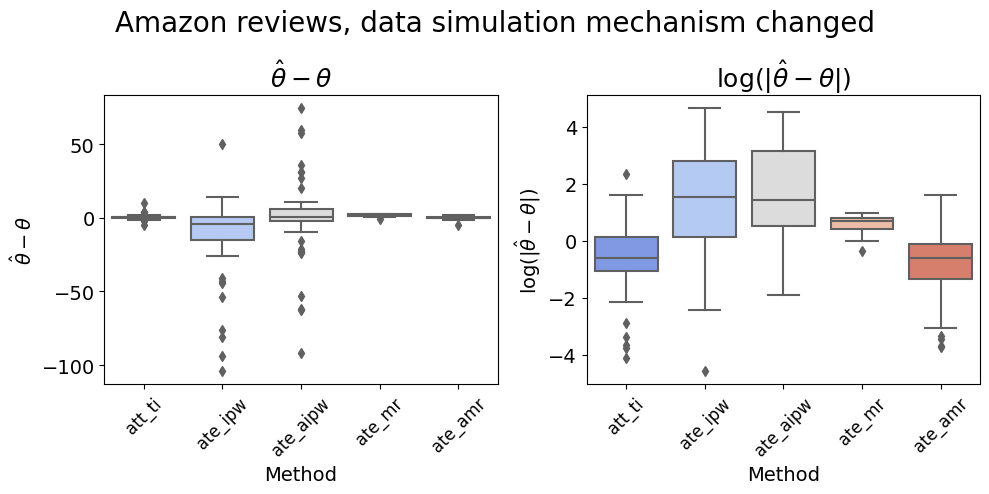

     Method  Mean_Diff   Std_Diff  Mean_Abs_Diff  Std_Abs_Diff       RMSE  \
0    att_ti   0.360121   1.890575       1.053205      1.610814   1.924568   
1   ate_ipw -13.526019  27.303689      16.717664     25.474779  30.470390   
2  ate_aipw  -0.147522  27.798923      16.303798     22.516396  27.799315   
3    ate_mr   1.820988   0.622000       1.866828      0.466729   1.924287   
4   ate_amr   0.003002   1.056656       0.718367      0.774907   1.056660   

    Std_RMSE  
0   3.781150  
1  54.607379  
2  55.597847  
3   1.244000  
4   2.113312  


In [3]:
# # Extract keys and true ATE
ate_results = load('results/music/ate_nn.joblib')
methods = [ 'att_ti',  'ate_ipw', 'ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 1000
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        # 'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        # 'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    # 'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    # 'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(10, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Amazon reviews, data simulation mechanism changed', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []


for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)
